Epoch 1/100
75/75 - 3s - loss: 0.0154 - val_loss: 0.0681 - 3s/epoch - 35ms/step
Epoch 2/100
75/75 - 0s - loss: 0.0061 - val_loss: 0.0427 - 148ms/epoch - 2ms/step
Epoch 3/100
75/75 - 0s - loss: 0.0053 - val_loss: 0.0393 - 143ms/epoch - 2ms/step
Epoch 4/100
75/75 - 0s - loss: 0.0050 - val_loss: 0.0361 - 141ms/epoch - 2ms/step
Epoch 5/100
75/75 - 0s - loss: 0.0046 - val_loss: 0.0328 - 143ms/epoch - 2ms/step
Epoch 6/100
75/75 - 0s - loss: 0.0043 - val_loss: 0.0298 - 141ms/epoch - 2ms/step
Epoch 7/100
75/75 - 0s - loss: 0.0040 - val_loss: 0.0252 - 142ms/epoch - 2ms/step
Epoch 8/100
75/75 - 0s - loss: 0.0037 - val_loss: 0.0239 - 145ms/epoch - 2ms/step
Epoch 9/100
75/75 - 0s - loss: 0.0033 - val_loss: 0.0186 - 143ms/epoch - 2ms/step
Epoch 10/100
75/75 - 0s - loss: 0.0030 - val_loss: 0.0194 - 142ms/epoch - 2ms/step
Epoch 11/100
75/75 - 0s - loss: 0.0028 - val_loss: 0.0153 - 143ms/epoch - 2ms/step
Epoch 12/100
75/75 - 0s - loss: 0.0025 - val_loss: 0.0120 - 142ms/epoch - 2ms/step
Epoch 13/100
75

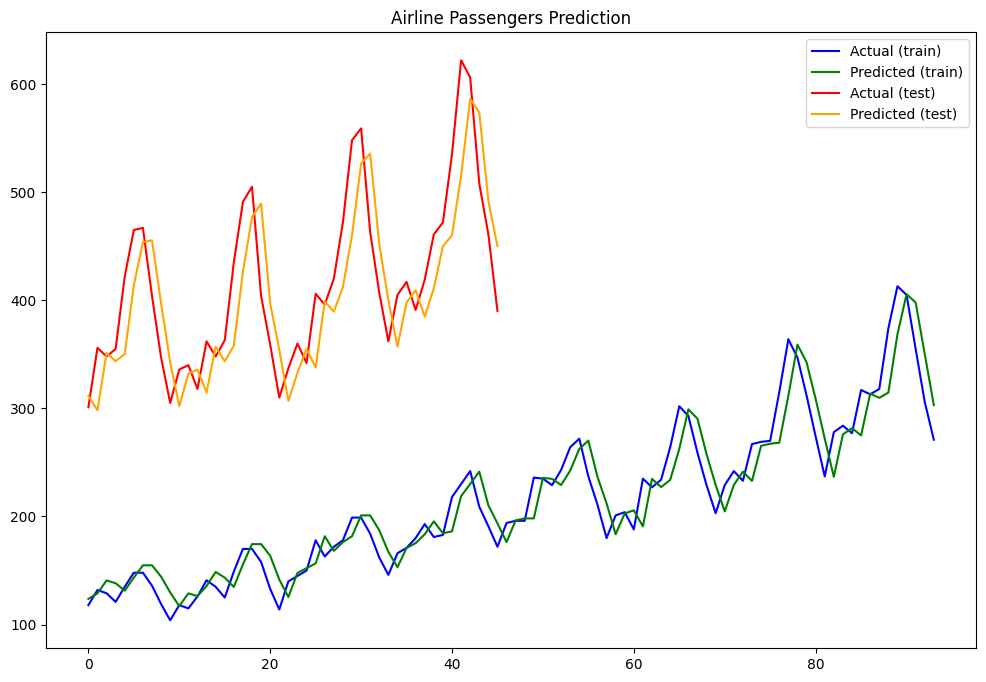

In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(7)

# Load the dataset from a CSV file
try:
    df = pd.read_csv('airline-passengers.csv', usecols=[1])
except FileNotFoundError:
    print("Error: File not found")
    exit()
except pd.errors.EmptyDataError:
    print("Error: Dataset is empty")
    exit()

# Convert the dataframe into a numpy array and change the datatype
dataset = df.values.astype('float32')

# Scale the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# Split the dataset into training and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Define a function to create a dataset matrix
def create_dataset(dataset, look_back=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-look_back-1):
        x = dataset[i:(i+look_back), 0]
        y = dataset[i + look_back, 0]
        data_X.append(x)
        data_Y.append(y)
    return np.array(data_X), np.array(data_Y)

# Create the training and test datasets
look_back = 1
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# Define the model
model = Sequential()
model.add(LSTM(units=4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=2, validation_split=0.2, callbacks=[es])

# Make predictions on the training and test data
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)


# Invert the scaling for the predicted data
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

# Calculate root mean squared error for training and test data
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

# Plot the predicted values and the actual values
plt.figure(figsize=(12, 8))
plt.plot(train_Y.reshape(-1), label='Actual (train)', color='blue')
plt.plot(train_predict.reshape(-1), label='Predicted (train)', color='green')
plt.plot(test_Y.reshape(-1), label='Actual (test)', color='red')
plt.plot(test_predict.reshape(-1), label='Predicted (test)', color='orange')
plt.title('Airline Passengers Prediction')
plt.legend()
plt.show()
